In [82]:
import pandas as pd
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [5]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
print(train_identity.shape)
print(train_transaction.shape)
data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
data = data.drop('TransactionID', axis=1)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [21]:
missing_cols = data.isnull().sum(axis=0)/len(data)
missing_cols = missing_cols[missing_cols >= 0.8]
data = data.drop(missing_cols.index,axis=1)
Y =  data.pop('isFraud')

In [23]:
dtypes = data.dtypes
for col in data:
    print(col, dtypes[col])

TransactionDT int64
TransactionAmt float64
ProductCD object
card1 int64
card2 float64
card3 float64
card4 object
card5 float64
card6 object
addr1 float64
addr2 float64
dist1 float64
P_emaildomain object
R_emaildomain object
C1 float64
C2 float64
C3 float64
C4 float64
C5 float64
C6 float64
C7 float64
C8 float64
C9 float64
C10 float64
C11 float64
C12 float64
C13 float64
C14 float64
D1 float64
D2 float64
D3 float64
D4 float64
D5 float64
D10 float64
D11 float64
D15 float64
M1 object
M2 object
M3 object
M4 object
M5 object
M6 object
M7 object
M8 object
M9 object
V1 float64
V2 float64
V3 float64
V4 float64
V5 float64
V6 float64
V7 float64
V8 float64
V9 float64
V10 float64
V11 float64
V12 float64
V13 float64
V14 float64
V15 float64
V16 float64
V17 float64
V18 float64
V19 float64
V20 float64
V21 float64
V22 float64
V23 float64
V24 float64
V25 float64
V26 float64
V27 float64
V28 float64
V29 float64
V30 float64
V31 float64
V32 float64
V33 float64
V34 float64
V35 float64
V36 float64
V37 float64
V

In [40]:
dtypes = data.dtypes
catg_none_binary = []

for col in data:
    if dtypes[col] == 'object':
        nuniq = data[col].nunique()
        if nuniq == 2:
            binary_values = data[col].value_counts().index
            mapper = dict(zip(binary_values, range(len(binary_values))))
            data.replace({col: mapper}, inplace=True)        
        else:
            catg_none_binary.append(col)

At split:  0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.231962	eval-logloss:0.244096
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.136358	eval-logloss:0.155287
[2]	train-logloss:0.099742	eval-logloss:0.128777
[3]	train-logloss:0.085505	eval-logloss:0.119061
[4]	train-logloss:0.078446	eval-logloss:0.114611
[5]	train-logloss:0.074033	eval-logloss:0.122696
[6]	train-logloss:0.070303	eval-logloss:0.139668
[7]	train-logloss:0.067991	eval-logloss:0.161371
[8]	train-logloss:0.065847	eval-logloss:0.160523
[9]	train-logloss:0.063842	eval-logloss:0.173938
[10]	train-logloss:0.061752	eval-logloss:0.195246
[11]	train-logloss:0.060264	eval-logloss:0.194027
[12]	train-logloss:0.058348	eval-logloss:0.193709
[13]	train-logloss:0.056567	eval-logloss:0.194089
[14]	train-logloss:0.055363	eval-logloss:0.204631
Stopping. Best iteration:
[4]	train-logloss:0.078446	eval-logloss:0.114611

PR AUC:  0.3599355996444527
At spli

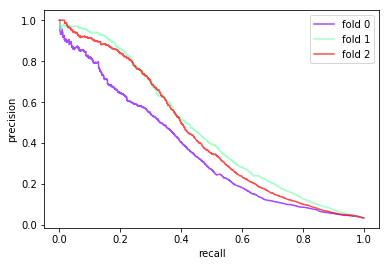

In [83]:
param = {
    'max_depth': 10,  
    'eta': 0.1,  
    'colsample_bytree': 0.8,
    'subsample':0.8,
    'n_estimators':100,  
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'min_child_weight':10,
    'tree_method': 'hist',
    'silent': 1
}
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds)
color=cm.rainbow(np.linspace(0, 1, n_folds))

for idx, (train_index, valid_index) in enumerate(skf.split(data, Y)):
    print('At split: ',idx)
    X_train, X_valid = data.iloc[train_index], data.iloc[valid_index]
    Y_train, Y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    
    
    encoder = ce.TargetEncoder(cols=catg_none_binary, smoothing=10).fit(X_train, Y_train)
    X_train = encoder.transform(X_train)
    X_valid = encoder.transform(X_valid)
    
    d_X_train = xgb.DMatrix(X_train, label=Y_train)
    d_X_valid = xgb.DMatrix(X_valid, label=Y_valid)
    
    watchlist = [(d_X_train,'train'), (d_X_valid, 'eval')]
    model = xgb.train(param, d_X_train, 
                      param['n_estimators'], 
                      evals=watchlist,
                      early_stopping_rounds=10, 
                      verbose_eval=True)
    
    valid_proba = model.predict(d_X_valid, ntree_limit=model.best_ntree_limit)
    pr_auc = average_precision_score(Y_valid, valid_proba)
    print('PR AUC: ', pr_auc)
    
    precision, recall, thresholds = precision_recall_curve(Y_valid, valid_proba)
    plt.plot(recall, precision, c=color[idx], label='fold '+str(idx), alpha=0.7)
    

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()